In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data from CSV
file_path = r'C:\Users\akjka\Desktop\high-speed trains operation data.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand the structure
print(data.head())

# Data Preprocessing
# Handle missing values (for simplicity, we will drop rows with missing values for now)
data = data.dropna()

# Encode categorical columns using Label Encoding (like train_direction, weather, etc.)
label_encoder = LabelEncoder()

# Example: Encoding 'weather' and 'train_direction'
data['weather'] = label_encoder.fit_transform(data['weather'])
data['train_direction'] = label_encoder.fit_transform(data['train_direction'])

# Function to handle invalid times
def convert_time_to_minutes(time_str):
    try:
        # Handle cases where the hour is 24 (which is invalid)
        if time_str.startswith("24"):
            return None  # We can return None or any placeholder for invalid data
        time_obj = pd.to_datetime(time_str, format='%H:%M:%S')
        return time_obj.hour * 60 + time_obj.minute
    except Exception as e:
        return None  # If time conversion fails, return None

# Convert time columns using the custom function
data['scheduled_arrival_time'] = data['scheduled_arrival_time'].apply(convert_time_to_minutes)
data['scheduled_departure_time'] = data['scheduled_departure_time'].apply(convert_time_to_minutes)
data['actual_arrival_time'] = data['actual_arrival_time'].apply(convert_time_to_minutes)
data['actual_departure_time'] = data['actual_departure_time'].apply(convert_time_to_minutes)

# Drop rows with invalid times (None values)
data = data.dropna(subset=['scheduled_arrival_time', 'scheduled_departure_time', 'actual_arrival_time', 'actual_departure_time'])

# Feature Engineering: Creating target variables for delays
data['arrival_delay'] = data['actual_arrival_time'] - data['scheduled_arrival_time']
data['departure_delay'] = data['actual_departure_time'] - data['scheduled_departure_time']

# Select features for the model (dropping time and date columns for now, since we want to focus on delays)
features = data[['train_number', 'train_direction', 'station_order', 'weather', 'temperature', 'major_holiday']]
target_arrival_delay = data['arrival_delay']
target_departure_delay = data['departure_delay']

# Split the data into training and testing sets
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(features, target_arrival_delay, test_size=0.2, random_state=42)
X_train, X_test, y_train_departure, y_test_departure = train_test_split(features, target_departure_delay, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model for arrival delay prediction
arrival_delay_model = RandomForestRegressor(n_estimators=100, random_state=42)
arrival_delay_model.fit(X_train, y_train_arrival)

# Predict on test data
y_pred_arrival = arrival_delay_model.predict(X_test)

# Evaluate the model using Mean Squared Error
arrival_mse = mean_squared_error(y_test_arrival, y_pred_arrival)
print(f'Mean Squared Error for Arrival Delay Prediction: {arrival_mse}')

# Initialize and train the Random Forest model for departure delay prediction
departure_delay_model = RandomForestRegressor(n_estimators=100, random_state=42)
departure_delay_model.fit(X_train, y_train_departure)

# Predict on test data
y_pred_departure = departure_delay_model.predict(X_test)

# Evaluate the model using Mean Squared Error
departure_mse = mean_squared_error(y_test_departure, y_pred_departure)
print(f'Mean Squared Error for Departure Delay Prediction: {departure_mse}')

# Plotting actual vs predicted delays for arrival and departure
plt.figure(figsize=(12, 6))

# Plot for Arrival Delay
plt.subplot(1, 2, 1)
plt.scatter(y_test_arrival, y_pred_arrival)
plt.xlabel('Actual Arrival Delay')
plt.ylabel('Predicted Arrival Delay')
plt.title('Actual vs Predicted Arrival Delay')

# Plot for Departure Delay
plt.subplot(1, 2, 2)
plt.scatter(y_test_departure, y_pred_departure)
plt.xlabel('Actual Departure Delay')
plt.ylabel('Predicted Departure Delay')
plt.title('Actual vs Predicted Departure Delay')

plt.tight_layout()
plt.show()


         date train_number train_direction                      station_name  \
0  2019-10-09           G1            down        Beijingnan Railway Station   
1  2019-10-09           G1            down           Jinanxi Railway Station   
2  2019-10-09           G1            down        Nanjingnan Railway Station   
3  2019-10-09           G1            down  Shanghaihongqiao Railway Station   
4  2019-10-10           G1            down        Beijingnan Railway Station   

   station_order scheduled_arrival_time scheduled_departure_time stop_time  \
0              1               09:00:00                 09:00:00      ----   
1              2               10:22:00                 10:24:00         2   
2              3               12:24:00                 12:26:00         2   
3              4               13:28:00                 13:28:00      ----   
4              1               09:00:00                 09:00:00      ----   

  actual_arrival_time actual_departure_time  arriv

In [6]:
import cuml
import cudf
import pandas as pd
from cuml.ensemble import RandomForestClassifier as cuRF
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 1: Load your data
data = pd.read_csv(r'C:\Users\akjka\Desktop\high-speed trains operation data.csv')

# Step 2: Prepare your data
# Replace '----' values in 'stop_time' and convert them to NaN
data['stop_time'] = data['stop_time'].replace('----', '0').astype(float)

# Convert categorical columns to numeric (using label encoding or one-hot encoding)
data['train_direction'] = data['train_direction'].map({'down': 0, 'up': 1})
data['weather'] = data['weather'].map({'sunny': 0, 'cloudy': 1, 'light rain': 2, 'overcast': 3, 'light rain': 4})

# Drop non-numeric columns like 'station_name' and 'train_number'
data = data.drop(columns=['station_name', 'train_number'])

# Step 3: Split your data into features and target
X = data.drop(columns=['arrival_delay'])  # Features
y = data['arrival_delay']  # Target

# Step 4: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Convert to cuDF (GPU-accelerated dataframe)
X_train_gpu = cudf.DataFrame.from_pandas(X_train)
X_test_gpu = cudf.DataFrame.from_pandas(X_test)
y_train_gpu = cudf.Series(y_train.values)
y_test_gpu = cudf.Series(y_test.values)

# Step 6: Initialize and train the cuML Random Forest model
rf_model = cuRF(n_estimators=100, max_depth=10)
rf_model.fit(X_train_gpu, y_train_gpu)

# Step 7: Make predictions and evaluate the model
y_pred_gpu = rf_model.predict(X_test_gpu)
y_pred_cpu = y_pred_gpu.to_array()  # Convert back to CPU array for accuracy calculation

# Step 8: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred_cpu)
print(f"Accuracy: {accuracy * 100:.2f}%")


ModuleNotFoundError: No module named 'cuml'

In [ ]:
import os

# Updating conda first
os.system('conda update conda -y')

# Creating a new conda environment and installing cuML with CUDA support
os.system('conda create -n cuml-env python=3.8 -y')
os.system('conda activate cuml-env')

# Install cuML with CUDA toolkit 11.2
os.system('conda install -c rapidsai -c nvidia -c conda-forge cuml=21.12 python=3.8 cudatoolkit=11.2 -y')

# Alternatively, use mamba if conda is slow or stuck
# os.system('conda install mamba -c conda-forge -y')
# os.system('mamba install -c rapidsai -c nvidia -c conda-forge cuml=21.12 python=3.8 cudatoolkit=11.2 -y')


In [ ]:
import os

# Force using the NVIDIA GPU (usually device 0)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Ensure the first GPU (usually NVIDIA) is used


In [ ]:
import tensorflow as tf

# Check if TensorFlow is using the GPU
if tf.config.experimental.list_physical_devices('GPU'):
    print("TensorFlow is using the GPU")
else:
    print("TensorFlow is not using the GPU")


In [12]:
import tensorflow as tf
print("CUDA Available: ", tf.test.is_built_with_cuda())


CUDA Available:  False


In [14]:
import torch
print(torch.cuda.is_available())


False


In [16]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [18]:
import tensorflow as tf

# List all physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) == 0:
    print("No GPU available")
else:
    print(f"Number of GPUs available: {len(physical_devices)}")
    print(f"GPU Details: {physical_devices}")


No GPU available


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))




Num GPUs Available:  1


In [22]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [26]:
import tensorflow as tf
import numpy as np

# Create a simple model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(5,)),
    tf.keras.layers.Dense(1)
])

# Create a random input
input_data = np.random.random((10, 5))

# Try running a prediction
output_data = model(input_data)
print(output_data)


tf.Tensor(
[[-0.03107389]
 [ 0.23109524]
 [ 0.10349568]
 [ 0.12372905]
 [ 0.13975994]
 [-0.16285366]
 [-0.19773996]
 [ 0.07594924]
 [ 0.19424835]
 [-0.08638588]], shape=(10, 1), dtype=float32)


C:\Users\akjka\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [2]:

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
file_path = "C:/Users/akjka/Desktop/high-speed trains operation data.csv"
data = pd.read_csv(file_path)

# Handle missing values
data = data.replace("----", np.nan)  # Replace '----' with NaN for easy cleaning
data = data.dropna()  # Drop rows with missing values

# Feature engineering
# Convert times to minutes since midnight
def time_to_minutes(time_str):
    if isinstance(time_str, str):
        time = pd.to_datetime(time_str, format="%H:%M:%S")
        return time.hour * 60 + time.minute
    return 0

data['scheduled_arrival_time'] = data['scheduled_arrival_time'].apply(time_to_minutes)
data['scheduled_departure_time'] = data['scheduled_departure_time'].apply(time_to_minutes)
data['actual_arrival_time'] = data['actual_arrival_time'].apply(time_to_minutes)
data['actual_departure_time'] = data['actual_departure_time'].apply(time_to_minutes)

# Convert categorical columns (e.g., weather, wind) to numerical using label encoding
data['weather'] = data['weather'].astype('category').cat.codes
data['wind'] = data['wind'].astype('category').cat.codes

# Extract features and target variable
X = data[['scheduled_arrival_time', 'scheduled_departure_time', 'station_order', 'weather', 'wind', 'temperature']]
y = data['arrival_delay']  # You can also use 'departure_delay' for another prediction

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [1]:
import tensorflow as tf

# Check if TensorFlow is using GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow is using {len(gpus)} GPU(s)")
    for gpu in gpus:
        print(f"GPU: {gpu}")
else:
    print("TensorFlow is not using a GPU")


TensorFlow is using 1 GPU(s)
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess the data
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))  # Reshape for CNN input
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))  # Reshape for CNN input
X_train, X_test = X_train / 255.0, X_test / 255.0  # Normalize to [0, 1]

# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Increase the batch size for training
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))


11501568/11490434 [==============================] - 2s 0us/step
Epoch 1/10
469/469 [==============================] - 15s 7ms/step - loss: 0.2314 - accuracy: 0.9316 - val_loss: 0.0627 - val_accuracy: 0.9808
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0597 - accuracy: 0.9818 - val_loss: 0.0483 - val_accuracy: 0.9848
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0416 - accuracy: 0.9869 - val_loss: 0.0393 - val_accuracy: 0.9878
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0314 - accuracy: 0.9901 - val_loss: 0.0442 - val_accuracy: 0.9868
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0250 - accuracy: 0.9920 - val_loss: 0.0290 - val_accuracy: 0.9906
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0205 - accuracy: 0.9938 - val_loss: 0.0337 - val_accuracy: 0.9890
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0185 -

In [5]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Load your CSV file
data = pd.read_csv("C:/Users/akjka/Desktop/high-speed trains operation data.csv")
# Check the columns
print(data.columns)
# Drop unnecessary columns (e.g., train_number, station_name)
data = data.drop(columns=["date", "train_number", "station_name", "scheduled_arrival_time", "scheduled_departure_time", "stop_time", "actual_arrival_time", "actual_departure_time", "temperature"])
# Handle missing values if any (e.g., replacing '----' with NaN and then filling them)
data.replace('----', None, inplace=True)
data = data.dropna()
# Encode categorical columns (train_direction, weather, wind, and major_holiday)
label_encoder = LabelEncoder()

# Encoding categorical columns
data['train_direction'] = label_encoder.fit_transform(data['train_direction'])
data['weather'] = label_encoder.fit_transform(data['weather'])
data['wind'] = label_encoder.fit_transform(data['wind'])
data['major_holiday'] = label_encoder.fit_transform(data['major_holiday'])

# Features and target variable (assuming you're predicting delays)
X = data.drop(columns=["arrival_delay", "departure_delay"])
y = data[["arrival_delay", "departure_delay"]]

# Normalize/Scale the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the model (with more complexity for higher GPU usage)
model = Sequential([
    Dense(512, activation='relu', input_dim=X_train.shape[1]),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2)  # Predicting both arrival and departure delays
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model with larger batch size for better GPU utilization
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test))


Index(['date', 'train_number', 'train_direction', 'station_name',
       'station_order', 'scheduled_arrival_time', 'scheduled_departure_time',
       'stop_time', 'actual_arrival_time', 'actual_departure_time',
       'arrival_delay', 'departure_delay', 'wind', 'weather', 'temperature',
       'major_holiday'],
      dtype='object')
Epoch 1/20
17199/17199 [==============================] - 91s 5ms/step - loss: 6035.5591 - mae: 15.9956 - val_loss: 6027.1104 - val_mae: 15.6762
Epoch 2/20
17199/17199 [==============================] - 94s 5ms/step - loss: 5987.4111 - mae: 16.2153 - val_loss: 6032.0938 - val_mae: 16.4601
Epoch 3/20
17199/17199 [==============================] - 92s 5ms/step - loss: 5977.6719 - mae: 16.2744 - val_loss: 6014.6021 - val_mae: 16.6278
Epoch 4/20
17199/17199 [==============================] - 92s 5ms/step - loss: 5966.7031 - mae: 16.2792 - val_loss: 5997.8037 - val_mae: 16.9295
Epoch 5/20
17199/17199 [==============================] - 92s 5ms/step - loss: 5963.

In [11]:
from tensorflow.keras.layers import Dropout

# Define the model with Dropout layers
model = Sequential([
    Dense(512, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),  # Add dropout to avoid overfitting
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(2)  # Predicting both arrival and departure delays
])

# Compile the model with a lower learning rate for stability
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='mean_squared_error', 
              metrics=['mae'])

# Train the model with a smaller batch size and higher epochs for more training time
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/5
34397/34397 [==============================] - 213s 6ms/step - loss: 6064.7915 - mae: 15.8644 - val_loss: 6084.7534 - val_mae: 15.1251
Epoch 2/5
34397/34397 [==============================] - 207s 6ms/step - loss: 6012.3086 - mae: 16.0243 - val_loss: 6010.9380 - val_mae: 16.2716
Epoch 3/5
34397/34397 [==============================] - 209s 6ms/step - loss: 6000.3970 - mae: 16.1237 - val_loss: 6004.7207 - val_mae: 16.2079
Epoch 4/5
34397/34397 [==============================] - 222s 6ms/step - loss: 5992.0757 - mae: 16.1886 - val_loss: 6007.4541 - val_mae: 15.7993
Epoch 5/5
34397/34397 [==============================] - 208s 6ms/step - loss: 5987.8706 - mae: 16.2056 - val_loss: 6011.3501 - val_mae: 16.5778


In [13]:
# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test)

# Print the first few predicted values to see the results
print("Predictions on Test Data:")
print(y_pred[:5])  # Show the first 5 predictions

# If you want to see how well the model performed, you can calculate the mean absolute error on the test set
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on Test Data: {mae}")


Predictions on Test Data:
[[9.04484   8.689043 ]
 [4.324617  3.9729254]
 [3.0336375 2.6395457]
 [7.575729  7.1812134]
 [3.0336375 2.6395457]]
Mean Absolute Error on Test Data: 16.577770378687546


In [15]:
# Assuming the model has two output values: arrival_delay and departure_delay
arrival_delay_pred = y_pred[:, 0]
departure_delay_pred = y_pred[:, 1]

# Calculate MAE for each
mae_arrival = mean_absolute_error(y_test['arrival_delay'], arrival_delay_pred)
mae_departure = mean_absolute_error(y_test['departure_delay'], departure_delay_pred)

print(f"Mean Absolute Error for Arrival Delay: {mae_arrival}")
print(f"Mean Absolute Error for Departure Delay: {mae_departure}")


Mean Absolute Error for Arrival Delay: 13.988370055532348
Mean Absolute Error for Departure Delay: 19.167170701842743


Epoch 1/5
34397/34397 [==============================] - 200s 6ms/step - loss: 6064.0923 - mae: 15.8152 - val_loss: 6019.6655 - val_mae: 16.2138
Epoch 2/5
34397/34397 [==============================] - 207s 6ms/step - loss: 6009.3359 - mae: 16.0095 - val_loss: 6019.6025 - val_mae: 16.4365
Epoch 3/5
34397/34397 [==============================] - 204s 6ms/step - loss: 6000.5415 - mae: 16.1092 - val_loss: 6002.8843 - val_mae: 15.9308
Epoch 4/5
34397/34397 [==============================] - 205s 6ms/step - loss: 5992.9551 - mae: 16.1368 - val_loss: 6020.6851 - val_mae: 16.2440
Epoch 5/5
34397/34397 [==============================] - 203s 6ms/step - loss: 5989.5093 - mae: 16.2142 - val_loss: 6021.9502 - val_mae: 16.8559


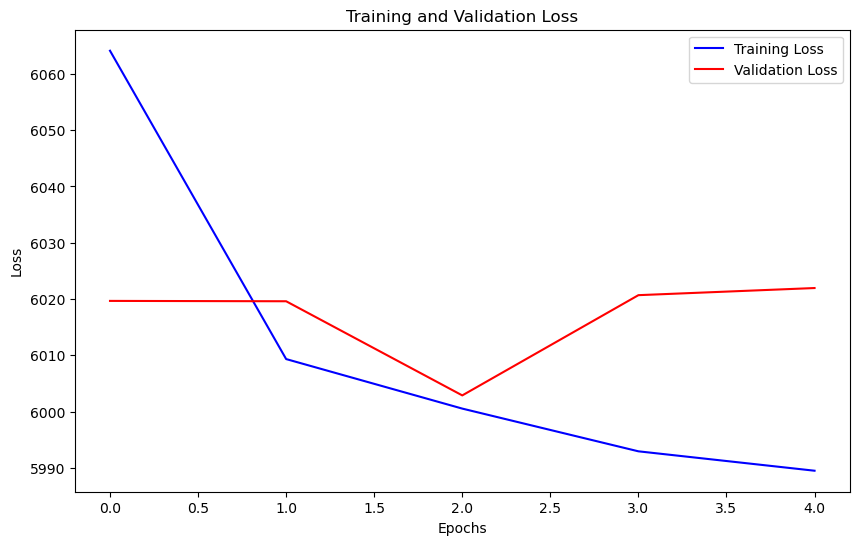

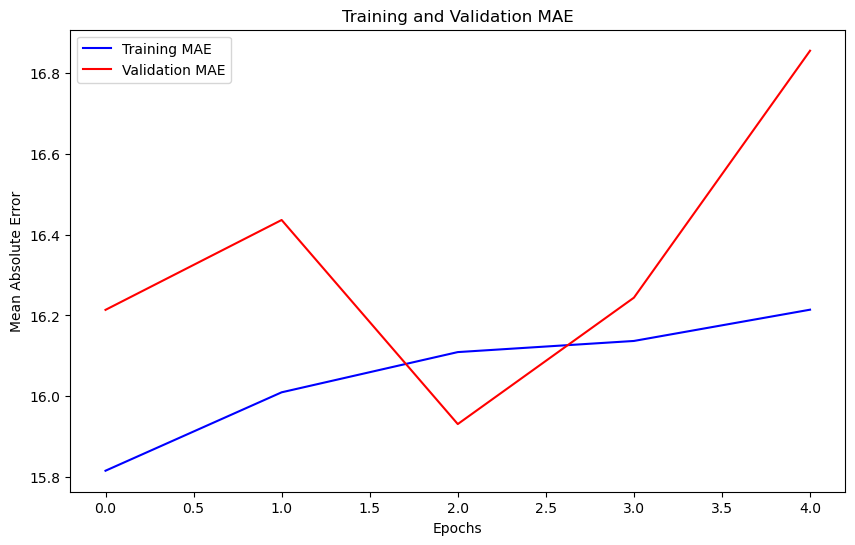

In [16]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# Load your CSV file
data = pd.read_csv("C:/Users/akjka/Desktop/high-speed trains operation data.csv")

# Drop unnecessary columns
data = data.drop(columns=["date", "train_number", "station_name", "scheduled_arrival_time", "scheduled_departure_time", "stop_time", "actual_arrival_time", "actual_departure_time", "temperature"])

# Handle missing values
data.replace('----', None, inplace=True)
data = data.dropna()

# Encode categorical columns
label_encoder = LabelEncoder()
data['train_direction'] = label_encoder.fit_transform(data['train_direction'])
data['weather'] = label_encoder.fit_transform(data['weather'])
data['wind'] = label_encoder.fit_transform(data['wind'])
data['major_holiday'] = label_encoder.fit_transform(data['major_holiday'])

# Features and target variable
X = data.drop(columns=["arrival_delay", "departure_delay"])
y = data[["arrival_delay", "departure_delay"]]

# Normalize/Scale the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the model (with Dropout for better generalization)
model = Sequential([
    Dense(512, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),  # Dropout layer
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(2)  # Predicting both arrival and departure delays
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='mean_squared_error', 
              metrics=['mae'])

# Train the model and save the history
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation MAE (Mean Absolute Error)
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE', color='blue')
plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()
